In [1]:
import pandas as pd # импортируем ряд библиотек
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import requests 
from urllib.parse import urlencode
from scipy import stats
from scipy.stats import ttest_ind
from tqdm.auto import tqdm
from scipy.stats import norm
from  scipy.stats import chi2_contingency
import pandahouse as ph
sns.set(
    font_scale = 2,
    style       ="whitegrid",
    rc          ={'figure.figsize':(20, 7)}
)

In [2]:
# Выгружаем данные напрямую с диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
public_key_2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
final_url_1 = base_url + urlencode(dict(public_key=public_key_1)) 
final_url_2 = base_url + urlencode(dict(public_key=public_key_2))
final_url_3 = base_url + urlencode(dict(public_key=public_key_3))
final_url_4 = base_url + urlencode(dict(public_key=public_key_4))
response_1 = requests.get(final_url_1)
response_2 = requests.get(final_url_2)
response_3 = requests.get(final_url_3)
response_4 = requests.get(final_url_4)
download_url_1 = response_1.json()['href'] 
download_url_2 = response_2.json()['href'] 
download_url_3 = response_3.json()['href']
download_url_4 = response_4.json()['href'] 
groups =       pd.read_csv(download_url_1, sep=';')
groups_add =   pd.read_csv(download_url_2, sep=',')
active_studs = pd.read_csv(download_url_3, sep=';')
checks =       pd.read_csv(download_url_4, sep=';')

In [3]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – тест) 
groups.head() 

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
#дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add.head()


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


# Задание 1  
### Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.  
### Предлагаем Вам ответить на следующие вопросы:
На какие метрики Вы смотрите в ходе анализа и почему?  
Имеются ли различия в показателях и с чем они могут быть связаны?  
Являются ли эти различия статистически значимыми?  
Стоит ли запускать новую механику на всех пользователей?  

## Далее будет "знакомство с данными" и выводы по "знакомству". Выводы между шагами 63 и 64. 

In [7]:
# Узнаем количество строк в каждой таблице

a = [groups, groups_add, active_studs, checks]

print('groups_shape =', a[0].shape[0])
print('groups_add_shape =', a[1].shape[0])
print('active_studs_shape =', a[2].shape[0])
print('checks_shape =', a[3].shape[0])

groups_shape = 74484
groups_add_shape = 92
active_studs_shape = 8341
checks_shape = 541


In [8]:
# Узнаем, есть ли дубликаты - их нет
for i in a:
    print(i.duplicated().sum())

0
0
0
0


In [9]:
# Узнаем, есть ли Null - нет
for i in a:
    print(i.isna().sum())

id     0
grp    0
dtype: int64
id     0
grp    0
dtype: int64
student_id    0
dtype: int64
student_id    0
rev           0
dtype: int64


In [10]:
# нет совпадений в двух таблицах по пользователям. Т.е они уникальны
groups.merge(groups_add, on = 'id') 

,id,grp_x,grp_y


In [11]:
# посмотрим соотношение "тестируемых" и "контрольных" в первой таблице
groups.grp.value_counts(normalize = True)

B    0.803032
A    0.196968
Name: grp, dtype: float64

In [12]:
# посмотрим соотношение "тестируемых" и "контрольных" во второй таблице
groups_add.grp.value_counts(normalize = True)

B    0.76087
A    0.23913
Name: grp, dtype: float64

In [13]:
 # в таблице с посещениями  сайта не отображено количесвто посещений - просто факт того, что как минимум один раз заходил
active_studs.student_id.value_counts() \
            .reset_index().student_id.unique()

array([1])

In [14]:
# в таблице с оплатами у каждого оплатившего одна оплата. Допускаю, что в некоторых случаях это может быть сумма оплата за
# исследуемый период, но по имещимся данным мы этого не узнаем
checks.student_id.value_counts() \
                 .reset_index().student_id.unique()

array([1])

In [15]:
# посмотрим, какие суммы тратили студенты и сколько студентов тратило конкретную сумму

checks.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
2910.0000     4
2890.0000     4
1980.0000     4
2099.0000     3
489.0000      3
1160.0000     3
1180.0000     2
2220.0000     2
2820.0000     2
597.0000      1
1388.0000     1
3260.0000     1
880.0000      1
3040.0000     1
796.0000      1
1968.0000     1
1339.0000     1
4650.0000     1
2900.0000     1
630.0000      1
1830.0000     1
1039.0000     1
1050.0000     1
1729.0000     1
2190.0000     1
Name: rev, dtype: int64

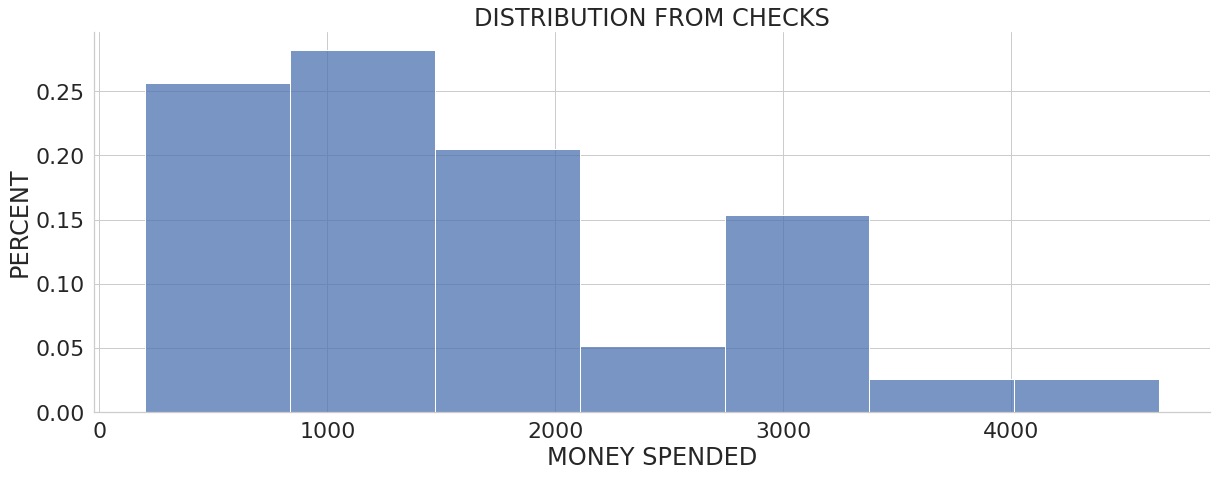

In [16]:
# гистограмма распределения всех чеков
qqq = checks.rev.value_counts().reset_index()
ax = sns.histplot(qqq['index'], stat = 'probability')
ax.set_xlabel('MONEY SPENDED')
ax.set_ylabel('PERCENT')
ax.set_title('DISTRIBUTION FROM CHECKS')
sns.despine()

In [17]:
# объединим две таблицы, т.к данные в них не повторяются и далее выясним, что 13 из второй таблицы заходили на сайт, а
# 1 оплатил услуги. Распределение тестовых и контрольных изменилось незначительно, т.к во второй таблице мало данных и
# они схожи по распределению с первой.
groups_full = pd.concat([groups, groups_add])
groups_full.grp.value_counts(normalize = True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

In [18]:
# все сджоинили (inner) и посмотрели соотношение. Оно неизменно
active_studs.merge(checks, on = 'student_id') \
            .rename(columns = {'student_id' : 'id'}) \
            .merge(groups_full, on = 'id') \
            .grp.value_counts(normalize = True)


B    0.80102
A    0.19898
Name: grp, dtype: float64

In [19]:
active_studs.merge(checks, on = 'student_id') # видим, что из зашедших на сайт оплатило через него 392 из 541.
                                              # значит есть и другие способы оплаты.
                                              # и то, не все те, кто зашел через сайт могли оплатить именно через него
                                              # но иных данных у нас нет и мы делаем допущение, что все зашедшие на сайт
                                              # через него и платили. С учетом что заход у каждого по 1ому и оплата по одной

,student_id,rev
0,1184303,1530.0000
1,3354191,1900.0001
2,3278734,1900.0000
3,720651,1980.0000
4,1232221,1900.0000
...,...,...
387,3890326,199.0000
388,1390994,398.0000
389,1516339,290.0000
390,3910596,597.0000


In [20]:
full_join = active_studs.merge(checks, on = 'student_id') \
                        .rename(columns = {'student_id' : 'id'}) \
                        .merge(groups_full, on = 'id')
full_join

,id,rev,grp
0,1184303,1530.0000,A
1,3354191,1900.0001,B
2,3278734,1900.0000,B
3,720651,1980.0000,A
4,1232221,1900.0000,B
...,...,...,...
387,3890326,199.0000,B
388,1390994,398.0000,A
389,1516339,290.0000,A
390,3910596,597.0000,B


In [21]:
full_join.grp.value_counts(normalize = True)

B    0.80102
A    0.19898
Name: grp, dtype: float64

In [22]:
# Выведем тех, кто воспользовался другими способами оплаты, т.е кто не заходил на сайт, но оплатил покупку (не через сайт)
# Видим, что количество групп пропорционально изначальному распределению кол-ва по группам
# в группе, оплативших (по допущению - все оплатившие и зашедщие оплатили через сайт) через сайт соотношение такое же
# как и в группе, оплативших не через сайт. это при обеих группах
full_join_where_without_web = checks.query('student_id not in @full_join.id') \
                                    .rename(columns = {'student_id' : 'id'}) \
                                    .merge(groups_full, on = 'id')

full_join_where_without_web.grp.value_counts(normalize = True)

B    0.805369
A    0.194631
Name: grp, dtype: float64

In [23]:
# Вывели тех, кто воспользовался другим способом оплаты, но сджойнили только с первой партией пользователей. соотношение 1в1
peace_join_where_without_web = checks.query('student_id not in @full_join.id') \
                                     .rename(columns = {'student_id' : 'id'}) \
                                     .merge(groups, on = 'id')

peace_join_where_without_web.grp.value_counts(normalize = True)

B    0.805369
A    0.194631
Name: grp, dtype: float64

In [24]:
# Если смотреть со второй партией - пусто. Т.е не было во второй таблице тех, кто оплатил, но не заходил на сайт
peace_join_where_without_web = checks.query('student_id not in @full_join.id') \
                                     .rename(columns = {'student_id' : 'id'}) \
                                     .merge(groups_add, on = 'id')

peace_join_where_without_web

,id,rev,grp


In [25]:
# вообще проверим есть ли совпадения из второй партии с посещениями и оплатой
active_studs.rename(columns = {'student_id' : 'id'}) \
            .merge(groups_add, on = 'id')

,id,grp
0,5723133,A
1,5951797,B
2,5730382,B
3,5739944,B
4,5945085,B
5,5700613,B
6,5729371,A
7,5777081,B
8,5740903,B
9,5760471,B


In [26]:
# посмотрим тоже что и выше, но соотношение A и B
active_studs.rename(columns = {'student_id' : 'id'}) \
            .merge(groups_add, on = 'id') \
            .grp.value_counts(normalize = True)

B    0.769231
A    0.230769
Name: grp, dtype: float64

In [27]:
# всего один из дополнительной таблицы совершил покупку и она ччерез сайт.
checks.rename(columns = {'student_id' : 'id'}) \
      .merge(groups_add, on = 'id')

,id,rev,grp
0,5740903,1900.0,B


In [28]:
# Дополнительно посмотрим распределение А и В в таблице с чеками.
checks.rename(columns = {'student_id' : 'id'}) \
      .merge(groups_full, on = 'id') \
      .grp.value_counts(normalize = True)

B    0.802218
A    0.197782
Name: grp, dtype: float64

In [29]:
# тоже самое, но с посещениями
active_studs.rename(columns = {'student_id' : 'id'}).merge(groups_full, on = 'id').grp.value_counts(normalize = True)

B    0.81561
A    0.18439
Name: grp, dtype: float64

In [30]:
# из первой таблицы процент зашедших на сайт
active_studs.rename(columns = {'student_id' : 'id'}).merge(groups, on = 'id').shape[0]/groups.shape[0]

0.11180924762365071

In [31]:
# из второй таблицы процент зашедших на сайт
active_studs.rename(columns = {'student_id' : 'id'}).merge(groups_add, on = 'id').shape[0]/groups_add.shape[0]

0.14130434782608695

In [32]:
# из объединенной таблицы процент зашедших на сайт
active_studs.rename(columns = {'student_id' : 'id'}).merge(groups_full, on = 'id').shape[0]/groups_full.shape[0]

0.11184563398412357

In [33]:
# Из первой таблицы процент купивших (не важно с сайта или нет)
checks.rename(columns = {'student_id' : 'id'}).merge(groups, on = 'id').shape[0]/groups.shape[0]

0.007249879168680522

In [34]:
# Из второй таблицы процент купивших (не важно с сайта или нет)
checks.rename(columns = {'student_id' : 'id'}).merge(groups_add, on = 'id').shape[0]/groups_add.shape[0]

0.010869565217391304

In [35]:
# из объединенной таблицы процент купивших (не важно с сайта или нет)
checks.rename(columns = {'student_id' : 'id'}).merge(groups_full, on = 'id').shape[0]/groups_full.shape[0]

0.00725434456125295

In [36]:
# из первой таблицы процент купивших с сайта (при допущении что все, кто заходил на сайт и купили - купили через сайт)
full_join.query('id in @ groups.id').shape[0]/groups.shape[0]

0.005249449546211267

In [37]:
# из второй таблицы процент купивших с сайта (при допущении что все, кто заходил на сайт и купили - купили через сайт)
full_join.query('id in @ groups_add.id').shape[0]/groups_add.shape[0]

0.010869565217391304

In [38]:
# из общей таблицы процент купивших с сайта (при допущении что все, кто заходил на сайт и купили - купили через сайт)
full_join.query('id in @ groups_full.id').shape[0]/groups_full.shape[0]

0.005256382750482729

In [39]:
# для удобства добавлю процентиль к каждой трате
full_join['pct'] = full_join['rev'].rank(pct=True)
full_join

,id,rev,grp,pct
0,1184303,1530.0000,A,0.585459
1,3354191,1900.0001,B,0.882653
2,3278734,1900.0000,B,0.719388
3,720651,1980.0000,A,0.933673
4,1232221,1900.0000,B,0.719388
...,...,...,...,...
387,3890326,199.0000,B,0.042092
388,1390994,398.0000,A,0.270408
389,1516339,290.0000,A,0.172194
390,3910596,597.0000,B,0.344388


In [40]:
# Посмотрим основные статистические данные в фулл джойне (те, кто оплатил через сайт (по допущению))
full_join.rev.describe()

count     392.000000
mean     1193.352050
std       827.136901
min       199.000000
25%       290.000000
50%       990.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [41]:
# посмотрим на распределение цен без разбивки на группы А и В
full_join.rev.value_counts()

1900.0000    93
290.0000     70
1900.0001    35
199.0000     32
840.0000     24
990.0000     22
690.0000     17
580.0000     11
590.0000     11
1140.0000    11
1530.0000     8
398.0000      7
870.0000      6
3660.0000     5
2910.0000     4
2890.0000     4
1160.0000     3
1980.0000     3
2099.0000     3
489.0000      3
2220.0000     2
2820.0000     2
2900.0000     1
1050.0000     1
1039.0000     1
2190.0000     1
1180.0000     1
796.0000      1
1388.0000     1
4650.0000     1
3040.0000     1
1968.0000     1
880.0000      1
1729.0000     1
1830.0000     1
1339.0000     1
3260.0000     1
597.0000      1
Name: rev, dtype: int64

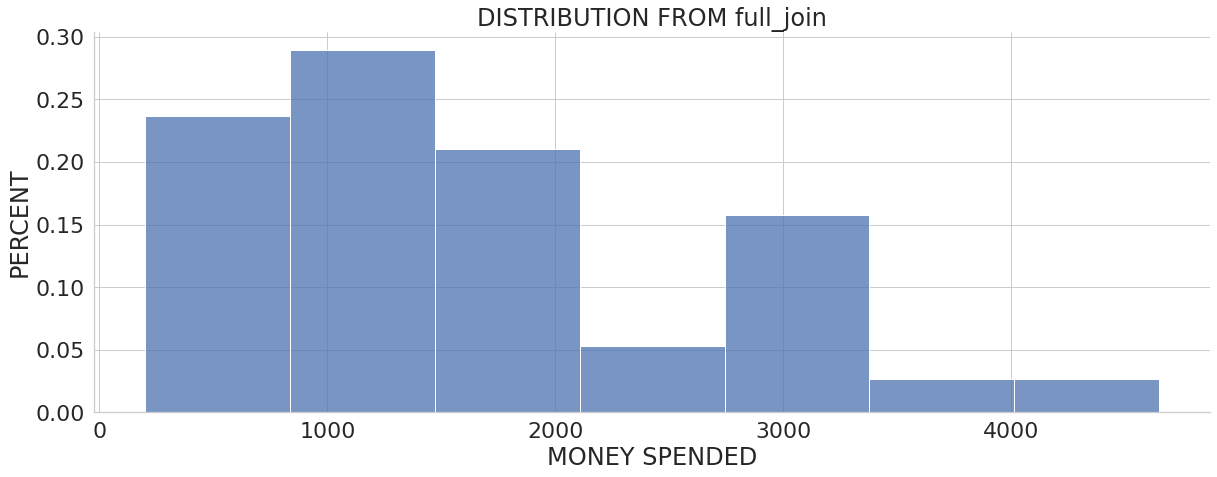

In [42]:
# Посмотрим общую гистограмму
qqqq = full_join.rev.value_counts().reset_index()
ax_1 = sns.histplot(qqqq['index'], stat = 'probability')
ax_1.set_xlabel('MONEY SPENDED')
ax_1.set_ylabel('PERCENT')
ax_1.set_title('DISTRIBUTION FROM full_join')
sns.despine()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


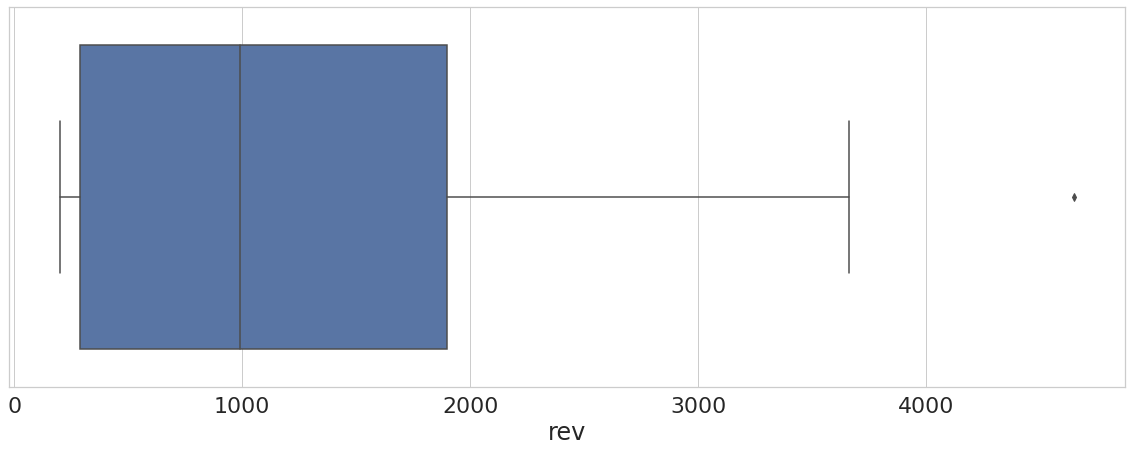

In [43]:
# Посмотрели боксплот без разбивки по группам
# видим один выброс
sns.boxplot(full_join['rev'])

In [44]:
# визуально кажется, что разница существенная (в медианах и средних по потраченным деньгам пользователей А и В)
full_join.groupby('grp')['rev'] \
         .agg(['count', 'mean', 'median']) # .reset_index()

,count,mean,median
grp,,,
A,78,933.589744,585.0
B,314,1257.878992,1140.0


In [45]:
# Теперь посмотрим по конкретным группам А и B
full_join.query('grp == "A"').rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [46]:
full_join.query('grp == "B"').rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [47]:
# большинство в "А" мало тратят (относительно В)
full_join.query('grp == "A"').rev.value_counts()

290.0     25
580.0      6
990.0      5
590.0      5
199.0      5
690.0      4
1530.0     3
3660.0     3
840.0      3
1140.0     2
489.0      2
1160.0     2
2820.0     2
2910.0     2
2890.0     1
1180.0     1
2900.0     1
1830.0     1
2220.0     1
870.0      1
398.0      1
1980.0     1
1039.0     1
Name: rev, dtype: int64

In [48]:
full_join.query('grp == "B"').rev.value_counts()

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
590.0000      6
398.0000      6
870.0000      5
580.0000      5
1530.0000     5
2890.0000     3
2099.0000     3
1980.0000     2
3660.0000     2
2910.0000     2
796.0000      1
1388.0000     1
489.0000      1
1160.0000     1
2190.0000     1
3040.0000     1
1968.0000     1
880.0000      1
1729.0000     1
2220.0000     1
1339.0000     1
4650.0000     1
1050.0000     1
597.0000      1
3260.0000     1
Name: rev, dtype: int64

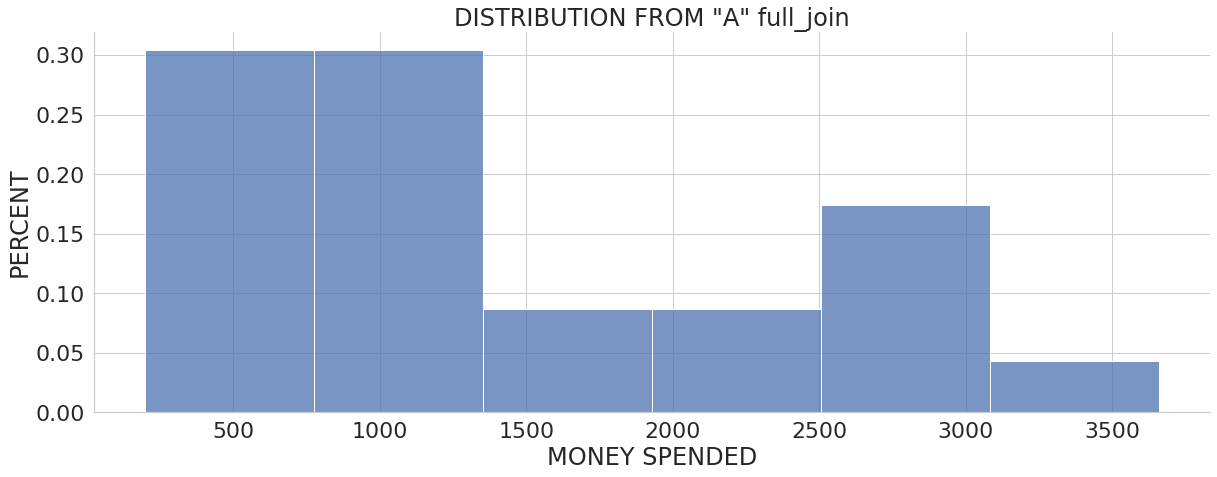

In [49]:
qqqqq = full_join.query('grp == "A"').rev.value_counts().reset_index()
ax_2 = sns.histplot(qqqqq['index'], stat = 'probability')
ax_2.set_xlabel('MONEY SPENDED')
ax_2.set_ylabel('PERCENT')
ax_2.set_title('DISTRIBUTION FROM "A" full_join')
sns.despine()

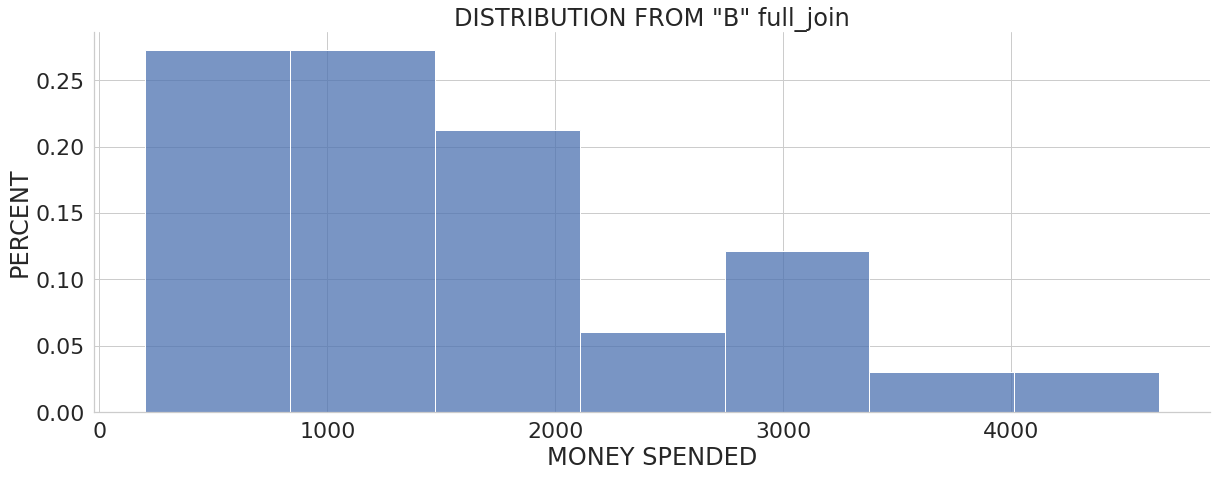

In [50]:
qqqqqq = full_join.query('grp == "B"').rev.value_counts().reset_index()
ax_3 = sns.histplot(qqqqqq['index'], stat = 'probability')
ax_3.set_xlabel('MONEY SPENDED')
ax_3.set_ylabel('PERCENT')
ax_3.set_title('DISTRIBUTION FROM "B" full_join')
sns.despine()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


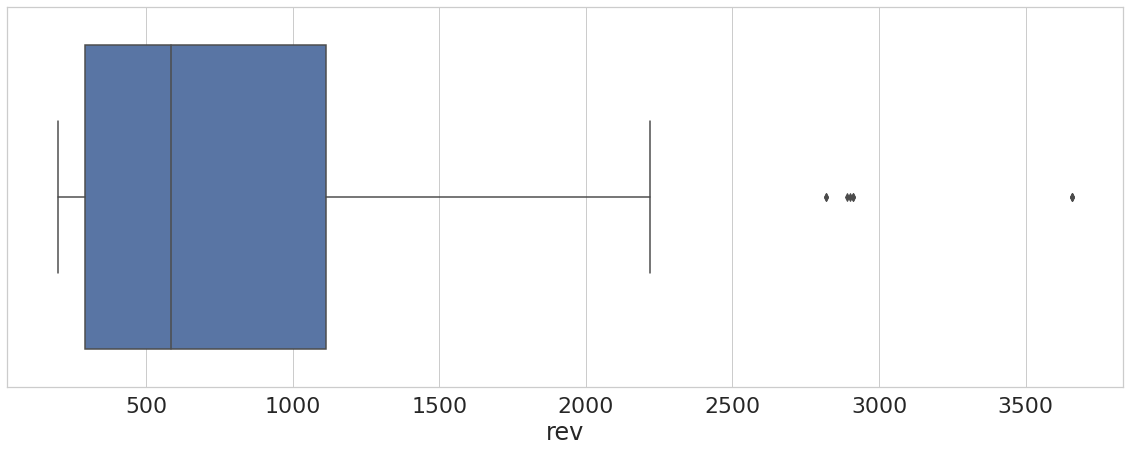

In [51]:
# Есть выбросы, но они не такого масштаба, что бы сильно повлиять на данные.
sns.boxplot(full_join.query('grp == "A"')['rev'])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


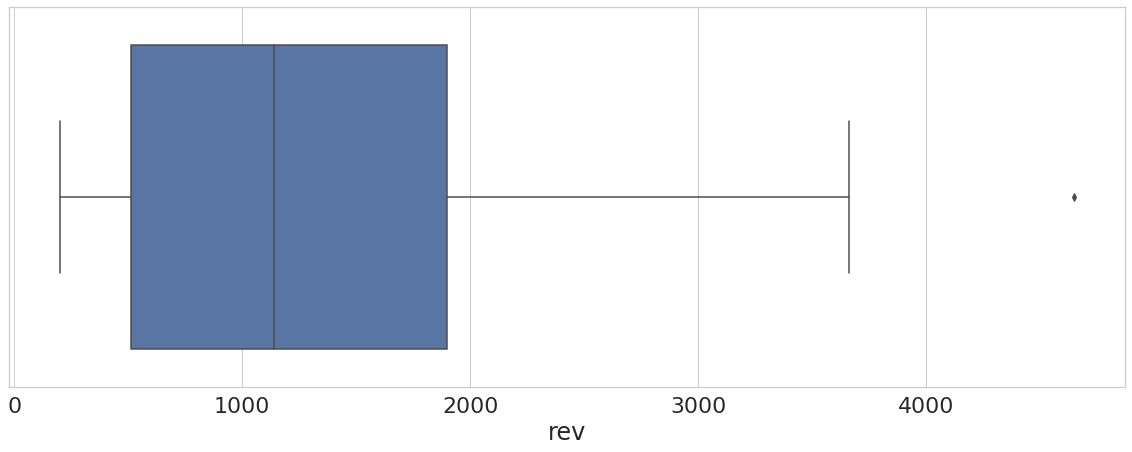

In [52]:
# один выброс. Медиана сильно дальше у этой группы, чем у A.
sns.boxplot(full_join.query('grp == "B"')['rev'])

#### Ниже будем проверять распределение трат в группах "A" и "B" на нормальность.  
#### H0 - распределение нормально, H1 - распределение не нормально.  
#### p-value отражает, какова вероятность получить такой результат при верности нулевой гипотезы.
#### В качестве стандарта, при котором мы не будем отвергать H0 выберем p-value >= 0.05.
#### Данный тест применяется на небольших выборках, поэтому используем метом sample()


In [53]:
# Проверим распределение трат в группе "А" на нормальность. 
# 9.800612588151125e-08 < 0.05 - H0 отвергается. Распределение не нормально.
stats.shapiro(full_join.query("grp == 'A'")['rev'].sample(35, random_state=17, replace = True))

ShapiroResult(statistic=0.6612098217010498, pvalue=9.800612588151125e-08)

In [54]:
# Повторим тест выше, но теперь без возврата использованных значений
# H0, сформулированная выше, отклоняется, поскольку 4.910687039227923e-06 < 0.05. 
# Принимаем H1 - распределение не нормальное.
stats.shapiro(full_join.query("grp == 'A'")['rev'].sample(35, random_state=17))

ShapiroResult(statistic=0.7670661807060242, pvalue=4.910687039227923e-06)

In [55]:
# Проведем тест с группой B.
# 5.692414539737456e-09 < 0.05. Отвергаем H0. Принимаем H1 - распределение не нормально.
stats.shapiro(full_join.query("grp == 'B'")['rev'].sample(75, random_state=17, replace = True))

ShapiroResult(statistic=0.7901068925857544, pvalue=5.692414539737456e-09)

In [56]:
# Повторим тест выше, но теперь без возврата использованных значений
# 8.42423446556495e-08 < 0.05. Отвергаем H0. Принимаем H1 - распределение не нормально.
stats.shapiro(full_join.query("grp == 'B'")['rev'].sample(75, random_state=17))

ShapiroResult(statistic=0.8313466310501099, pvalue=8.42423446556495e-08)

предварительно проведу t test (в данном случае сравниваются ARPPU), хотя и не планирую его использовать в качестве основного: выборки не большие, распределение не нормальное: лучше воспользоваться иными тестами.
H0 - средние двух групп стат. значимо не отличаются. H1 - средние двух групп отличаются стат. значимо

In [57]:
# 0.0018562025265765867 < 0.05. Вероятность получения такого p-value при верности H0 - 0.0018562025265765867
# Отвергаем H0, принимаем H1.
stats.ttest_ind(full_join.query("grp == 'A'")['rev'], full_join.query("grp == 'B'")['rev'])

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

In [58]:
# Теперь нужно подготовить таблицу для ARPU и CR, т.к в них нужно учитывать пользователей, которые заходили на сайт.
# Сначала сделаю Inner join с зашедшими на сайт и со всеми пользователями из двух таблиц, 
# потом left join таблицу со всеми, купившими через сайт (при допущении, что зашедший на сайт и купивший - купил через сайт)
join_for_ARPU_CR = active_studs.rename(columns = {'student_id': 'id'}) \
                               .merge(groups_full, on = 'id') \
                               .merge(full_join, how = 'left', on = 'id') \
                               .rename(columns = {'grp_x' : 'grp'}) \
                               .fillna(0)
         
join_for_ARPU_CR = join_for_ARPU_CR.drop(columns={'grp_y'})
join_for_ARPU_CR

,id,grp,rev,pct
0,581585,A,0.0,0.000000
1,5723133,A,0.0,0.000000
2,3276743,B,0.0,0.000000
3,4238589,A,0.0,0.000000
4,4475369,B,0.0,0.000000
...,...,...,...,...
8336,1794344,B,0.0,0.000000
8337,296883,B,0.0,0.000000
8338,3598448,B,0.0,0.000000
8339,3610547,B,290.0,0.172194


In [59]:
# Предварительно посмотрим на ARPU выборок. Почему такая медиана - понятно. Среднее сильно отличается. 
# Данные с точки зрения нормальности распределения итд не должны были измениться,
# Поэтому буду использовать тот же статистический метод, что и с ARPPU
join_for_ARPU_CR.groupby('grp')['rev'] \
                .agg(['count', 'mean', 'median']) # .reset_index()

,count,mean,median
grp,,,
A,1538,47.347204,0.0
B,6803,58.058798,0.0


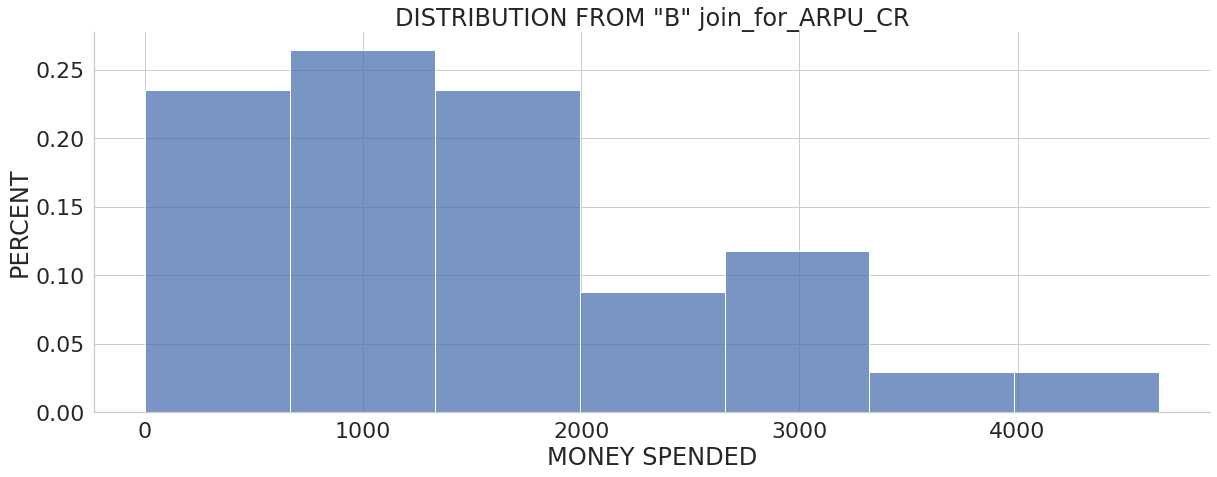

In [60]:
# Распределение очень похоже на то, что было при просмотре данных только по покупкам через сайт. Оно и понятно
qqqqqqq = join_for_ARPU_CR.query('grp == "B"').rev.value_counts().reset_index()
ax_4 = sns.histplot(qqqqqqq['index'], stat = 'probability')
ax_4.set_xlabel('MONEY SPENDED')
ax_4.set_ylabel('PERCENT')
ax_4.set_title('DISTRIBUTION FROM "B" join_for_ARPU_CR')
sns.despine()

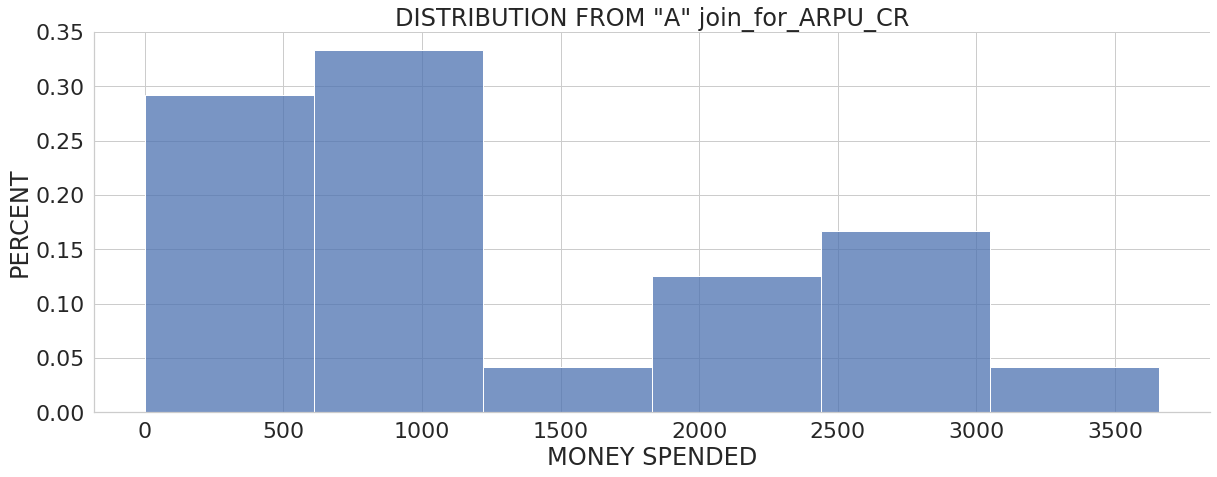

In [61]:
# Распределение очень похоже на то, что было при просмотре данных только по покупкам через сайт. Оно и понятно
qqqqqqqq = join_for_ARPU_CR.query('grp == "A"').rev.value_counts().reset_index()
ax_5 = sns.histplot(qqqqqqqq['index'], stat = 'probability')
ax_5.set_xlabel('MONEY SPENDED')
ax_5.set_ylabel('PERCENT')
ax_5.set_title('DISTRIBUTION FROM "A" join_for_ARPU_CR')
sns.despine()

In [62]:
# Что касается CR:
# Не понятно, статзначимо ли различие или нет. Я думаю использовать ХИ квадрат Пирсона, потому что
# Распределение ненормальное, группы не взаимосвязаны между собой и, грубо говоря, у нас у каждая группа делится на 
# просто зашедших и на зашедних и купивших (т.е присутствует качественный тип данных)
print('CR_A =', len(join_for_ARPU_CR.query('grp == "A" and rev != 0.0')) / len(join_for_ARPU_CR.query('grp == "A"')))
print('CR_B =', len(join_for_ARPU_CR.query('grp == "B" and rev != 0.0')) / len(join_for_ARPU_CR.query('grp == "B"')))

CR_A = 0.05071521456436931
CR_B = 0.046156107599588415


## Выводы при осмотре данных:   
1) Каждый студент, если и был замечен в посещениях, то только один раз. Тоже самое и с оплатой - все по одному разу  
2) использовать стоит обе таблицы с группами, т.к во второй все же одна покупка была, причем через сайт.
   покупка человека из дополнительной таблицы не является выбросом   
3) Т.к не все оплатившие товар/услугу посещали сайт - делаем вывод, что оплата возможна не только через сайт  
4) Т.к данные ограничены, сделаем допущение, что все, кто заходил на сайт и совершил оплату - сделал это через сайт.  
5) И в объединенной таблице (о принадлежности пользователей к тестовой группе) и в таблице тех, кто оплатил товар через сайт (по допущению, что все, кто заходил на сайт и совершил оплату сделали это через сайт) и среди тех, кто оплатил не через сайт и, соответственно среди тех, кто вообще оплатил и среди тех, кто зашел на сайт соотношение A к B примерно 1/5, хотя и среди зашедших на сайт это соотношение чуть более заметно изменено. Но по логике на заход на сайт фича, которая может проявится только если зайти на сайт, повлиять никак не могла   
6) Из второй части таблицы с пользователями (меньшей) % зашедших на сайт - 14,13 % (13 из 92 зашли на сайт), а из первой (крупной) - 11,18% (8328 зашедших из 74 484 человек), Общий - 0,11,18. Стоит ли проверить, статистически значимы ли различия?  
7) Из второй части таблицы с пользователями (меньшей) % купивших (не важно через сайт или нет) - 10,87%, а во второй - 0,7%. Общее - 0,7% - во второй таблице выборка слишком мала. Мб проверю на статистически значимые различия  
8) Из второй части таблицы с пользователями (меньшей) % купивших (только через сайт, при допущении, что все, кто зашел на сайт и кто сделал покупку - сделали ее через сайт) - 10,87 % (как и в п. 7), из первой таблицы - 0,5%, из общей: 0,5 %  
9) Не вижу смысла проводить A/A тест между groups и groups_add, т.к во второй таблице (дополнительные пользователи) очень мало наблюдений и там нет результатов-выбросов, которые существенно могли бы повлиять на результат.  
10) Поскольку мы принимаем за оплатившего через сайт того, кто совершил оплату и зашел на сайт одновременно, клиент, не зашедший на сайт никак не мог познакомится с новой платежной механикой, а значит наше изменение в механике на заход на сайт повлиять не могло (можно придумать ситуации, когда могло бы - например е-мейл рассылка с информацией о новой платежной системе, но считаю, что такие моменты мы не должны учитывать). Также Поскольку соотношение в численности групп остается примерно одним и тем же , считаю, что новая платежная система на заход на сайт повлиять не могла и метрики, связанные с этим я проверять не вижу смысла. т.к  сильных выбросов нет, будем считать "среднее", а не медиану. Предполагаемые метрики:

##### А) ARPPU - сравним, являются ли статичтически значимыми различия между группами А и В в потраченных средствах (среднее) на оплатившего пользователя (через сайт. с поправкой на то, что посетивший сайт и оплативший - сделал это через сайт). Для этого критерия буду использовать бутсрап, как наиболее "неприхотливый" тест, т.к выборка не очень большая, а распределение ненормально, выбрсов хоть и мало - но они есть (t-test не лучшая идея в таком случае, даже с логорифмом). Хи квадрат Пирсона также в данном случае не  подходит, т.к сравниваем среднее и тип данных - количественные (деньги). Ho - средний чек обеих групп, среди тех, кто оплатил через сайт (по допущению, что побывавший на сайте и оплативший, сделал это через сайт) стат. значимо не отличается. H1 - средний чек обеих групп, среди тех, кто оплатил через сайт (по допущению, что побывавший на сайте и оплативший, сделал это через сайт) стат. значимо отличается (при верной гипотезе H1, учитывая результаты, очевидно, что группа B более "успешная")  
##### Б) ARPU - сравним, являются ли статичтически значимыми различия между группами А и В в потраченных средствах (среднее) на пользователя, зашедшего на сайт. Использую тоже самое, что и в слуае с подсчетом ARPPU (бутстрап).  Ho - средний чек обеих групп, среди тех, кто  оплатил через сайт (с учетом всех внутри группы, кто заходил на сайт), стат. значимо не отличается. H1 - средний чек групп, среди тех, кто  оплатил через сайт (с учетом всех внутри группы, кто заходил на сайт), стат. значимо различаются  
##### В) CR - сравним, являются ли статичтически значимыми различия между группами А и В в отношении числа пользователей, зашедших на сайт к числу пользователей, совершивших покупку на сайте (при допущении, что любой, кто зашел на сайт и купил - сделал покупку через сайт). Думаю, стоит воспользоваться хи^2 Пиросана.  Кратко: Распределение ненормальное, группы не взаимосвязаны между собой и, грубо говоря, у нас у каждая группа делится на просто зашедших и на зашедних и купивших (т.е присутствует качественный тип данных). В таком случае, лучшим тестом будет ХИ^2 Пирсона. Ho - CR стат. значимо между группами не отличается, новая механика на сайте никак не влияет на количество покупок относительно заходов на сайт, по сравнению со старой механикой. H1 - CR стат. значимо отличается между группами, новая механика на сайте влияет на количество покупок относительно заходов на сайт, по сравнению со старой механикой.  
P.s. Во всех тетсах будем брать уровень значимости 0,05 (5%). Это стандарт, и более жесткий уровень значимости (например) 0,01 (1%), в данном случае, считаю, ни к чему.

### Найдем ARPPU с помощью bootstrap

In [63]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2500, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

H0 - средний чек обеих групп, среди тех, кто оплатил через сайт (по допущению, что побывавший на сайте и оплативший, сделал это через сайт) стат. значимо не отличается в двух группах  
H1 - средний чек обеих групп, среди тех, кто оплатил через сайт (по допущению, что побывавший на сайте и оплативший, сделал это через сайт) стат. значимо отличается в двух группах

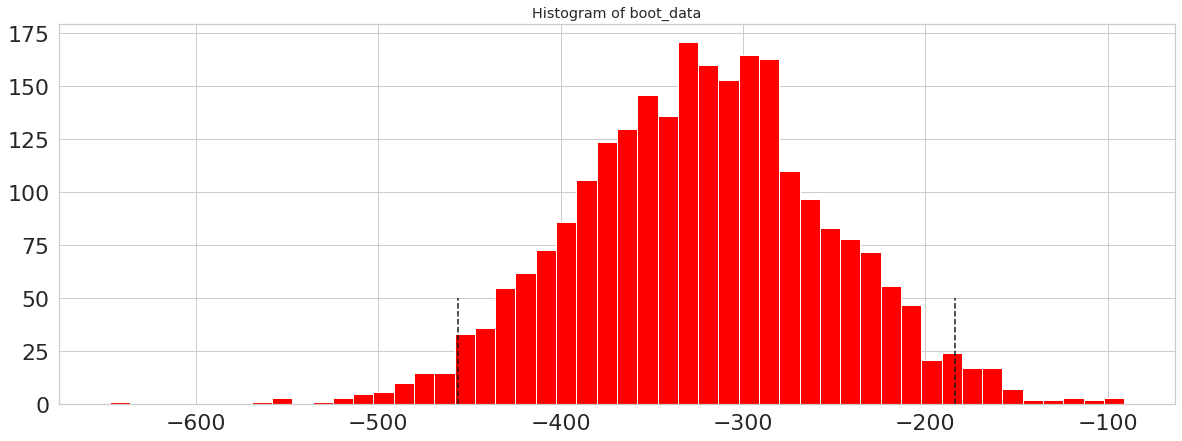

4.041789835426994e-06

In [64]:
### Вероятность получения такого p-value при верности H0 - 4.041789835426994e-06, что меньше 0,05.
### Отвергаем H0, принимаем H1.

ARPPU_mean = get_bootstrap(full_join.query('grp == "A"')['rev'], full_join.query('grp == "B"')['rev'])
ARPPU_mean['p_value']

In [65]:
full_join.query('grp == "A"')['rev']

0      1530.0
3      1980.0
10      580.0
14     2910.0
17      690.0
        ...  
379    3660.0
382    2910.0
383     290.0
388     398.0
389     290.0
Name: rev, Length: 78, dtype: float64

### Найдем ARPU с помощью bootstrap

Ho - средний чек обеих групп, среди тех, кто  оплатил через сайт (с учетом всех внутри группы, кто заходил на сайт), стат. значимо не отличается.  
H1 - средний чек групп, среди тех, кто  оплатил через сайт (с учетом всех внутри группы, кто заходил на сайт), стат. значимо различаются  

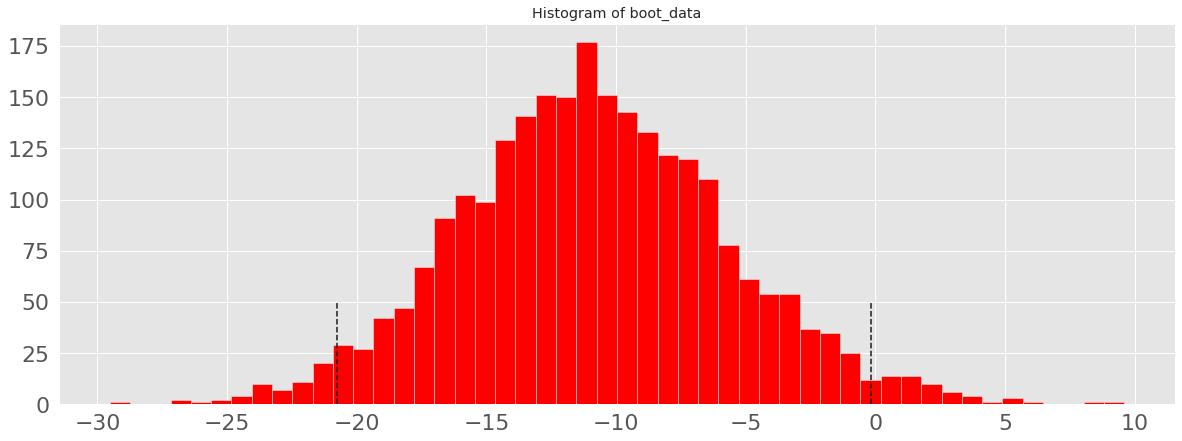

0.03476360621718626

In [66]:
# Вероятность получения такого p-value при верности H0 - 0.03476360621718626, что меньше 0,05.
# Отвергаем H0, принимаем H1.
ARPU_mean = get_bootstrap(join_for_ARPU_CR.query('grp == "A"')['rev'], join_for_ARPU_CR.query('grp == "B"')['rev'])
ARPU_mean['p_value']

### Найдем CR с помощью ХИ^2 Пирсона

Используем ХИ^2 Пирсона для того, что бы узнать, различается ли стат. значимо CR (процент тех, кто зашел на сайт и купил от тех, кто зашел на сайт) групп.
H0 - CR стат. значимо не различается. H1 - CR различается стат. значимо.

In [67]:
# P-value = 0.48625 (48,6%), что намного больше 0.05 (5 %).
# Вероятность получения такого p-value при верности H0 = 48,6%. Мы не можем отвергнуть H0
for_CR = np.array([[len(join_for_ARPU_CR.query('grp == "A" and rev != 0.0')),\
                   len(join_for_ARPU_CR.query('grp == "A"')) - len(join_for_ARPU_CR.query('grp == "A" and rev != 0.0'))],\
                   [len(join_for_ARPU_CR.query('grp == "B" and rev != 0.0')),\
                   len(join_for_ARPU_CR.query('grp == "B"')) - len(join_for_ARPU_CR.query('grp == "B" and rev != 0.0'))]]) 

CR_chi2_contingency = chi2_contingency(for_CR)
print('chisq-statistic=%.4f, p-value=%.5f, df=%i expected=%s'%CR_chi2_contingency)

chisq-statistic=0.4848, p-value=0.48625, df=1 expected=[[  72.28102146 1465.71897854]
 [ 319.71897854 6483.28102146]]


In [68]:
# Итог по метрикам и гипотизам к ним.
p = {'ARPPU': [False, True], 'ARPU': [False, True], 'CR': [True, False]}
pd.DataFrame(data=p, index=['H0', 'H1'])

,ARPPU,ARPU,CR
H0,False,False,True
H1,True,True,False


In [69]:
for_CR

array([[  78, 1460],
       [ 314, 6489]])

# Выводы по заданию 1 и ответы на вопросы:  

### 1) На какие метрики Вы смотрите в ходе анализа и почему?  

Ответ: Метрики, на которые я решил обратить внимание и сравнить их стат. значимое различие в группах A и B:   
А) ARPPU - средний чек тех, кто совершил оплату на сайте (при допущении, что все, кто зашел на сайт и оплатил - сделали это через сайт). В целом, у нас есть только информация по заходам на сайт и по суммам, потраченным через сайт (а также  через что-то иное). Соответственно, изменение механики оплаты могло повлиять на размер оплаты, или количество оплат разными пользователями (учитываем, что в данных у нас один и тот же пользователь не совершает покупку дважды, возможно автоматом покупки суммируются по каждому пользователю). Также можно было рассмотреть вариант с тем, что одна из групп чаще другой заходит на сайт, но во первых, как изменение механики оплаты могло повлиять на количество заходов на сайт, если что бы увидеть эти изменения, сначала нужно зайти на сайт, во вторых, я визуально посмотрел сооношение групп A и B в том числе по заходам на сайт - оно везде примерно 1/5, хотя в случае с заходом на сайт почему-то ближе к 1/4, однако я считаю, что именно логикой и недостаточным изменением соотношения заходов на сайт относительно соотношения выборок A и B позволяет нам не проверять гипотезу о влиянии изменения механики на количество заходов на сайт (к слову, у нас нет информации по количеству заходов каждым пользователем, только о факте хотя бы одного захода). В связи с вышеизложенным, сверять стат. значимые отличия (между A и B) среднего чека тех, кто совершил оплату на сайте (с учетом ранее озвученным допущением), считаю одним из немногих возможных вариантов, в условиях ограниченности данных. Мой выбор пал на среднее, а не медиану, потому что выбросов почти не было и среднее вполне подойдет. При этом, я считаю странным, что измение механики оплаты могло повлиять на ARPPU. Гораздо логичнее было бы, если бы механика позволила привлечь больше/меньше студентов к оплате - появился новый удобный/неудобный способ. Свои предположения на этот счет я изложу при ответе на второй вопрос.  
Б) ARPU - средний чек тех, кто совершил оплату на сайте (при допущении, что все, кто зашел на сайт и оплатил - сделали это через сайт) с учетом всех пользователей внутри группы, которые зашли на сайт. Многоие описанное в подпункте A) справедливо и для ARPU. Оно могло бы быть отличным от ARPPU (в контексте стат. значимости), если бы CR значительно отличался друг от друга, поэтому данную метрику также стоило проверить. Опять же, у меня есть некоторое непонимание, как механика оплаты на сайте могла повлиять на данную метрику, но об этом в ответе на 2 вопрос.  
В) CR  - Отношение числа тех (внутри групп A и B), кто оплатил покупку через сайт (при допущении, что все, кто зашел на сайт и оплатил - сделали это через сайт) к тем, кто зашел на сайт (выбрали не всех, а тех, кто именно зашел на сайт, потому, что те, кто на сайт не зашел, не могли увидеть новую механику оплаты (впрочем как и старую)). Именно на этот показатель должна была повлиять измененная механика оплаты больше всего (кому-то стало удобнее платить или наоборот, соответственно больше человек приобрело услугу от тех, кто зашел на сайт). Однако, мне не удалось найти стат. значимых различий в данной метрике.  

### 2) Имеются ли различия в показателях и с чем они могут быть связаны?  3) Являются ли эти различия статистически значимыми? 

Ответ: В соответствии с проведенными экспериментами, выявлено, что ARPPU у групп A и B отличается статзначимо. ARPU также стат. значимо отличается. Что касается CR - мы не смогли отвергнуть нулевую гипотезу, а значит принимаем, что CR групп A и B стат. значимо не отличается. Вопрос: в связи с чем могут быть связаны данные различия/отсутствия различий между группами с новой механикой оплаты и со старой механикой? 
Насчет стат. значимых изменений ARPPU и ARPU и отсутствия стат. значимых изменений в CR в группе A и B - сложно понять, учитывая, что по логике новая механика оплаты никак средний чек не должна была увеличить, а вот CR, наоборот, мог измениться. Могу лишь предложить один из вариантов, когда такое все же могло произойти, но он несколько надуманный:  
    Новая механика в оплате лучше работает, допустим с айфоном, но хуже с андройдом. В результате в группе B, где механика была изменена, было больше пользователей с айфоном, но вот пользователей с андройдом уменьшилось. В результате CR не поменялся, но т.к пользователи айфона в среднем больше зарабатывают (допустим), то и татить они могут больше, что увеличило средний чек в группе B. Но это все теории - данных слишком мало, что бы сделать полноценный вывод, основываясь на них. В целом, я придерживаюсь мнения, что на ARPPU и ARPU повлиял еще один фактор, о котором у нас нет данных в данный момент.

### 4) Стоит ли запускать новую механику на всех пользователей?  

Ответ: результаты говорят, что да. Однако, я считаю, что новая механика оплаты в первую очередь должна была повлиять на CR, а не на ARPU и ARPPU. Сложно представить ситуацию, когда более удобный или менее удобный способ оплаты через сайт мог серьезно повлиять на средний чек (в п.2 я попытался представить такую ситуацию). Я считаю, что раз с изменением в лучшую сторону CR новая механика не справляется, а ARPU и ARPPU новая механика оплаты через сайт не должна была увеличить, нам нужно повременить с запуском новой механики и найти реальные причины, почему ARPU и ARPPU у группы B изменилось в лучшую сторону. Могут быть факторы, которые коррелируют с новой системой оплаты и уже они влияют на ARPU и ARPPU. Возможно, окажется, что я не прав и новая механика оплаты может сама по себе повлиять на средний чек, но перед этим нужно проверить другие варианты, более логичные и вероятные.

# Задание 2 SQL

### 2.1. Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.  Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц. Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин. 



In [70]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [71]:
#-- запрос написан для многоразового использования, потому что "текущий месяц" - явно "максимальный месяц + год", 
#содержащийся в таблице и при ее обновлении данных, код сработает как и должен. Да, тут два подзапроса, 
# но зато код не под конкретный месяц. Также есть момент, что под очень усердным учеником понимается ученик, решивший
# ровно 20 горошин, если судить по условию, но я думаю, логично, что тот, кто решил 21 горошину - тоже очень усердный,
# если, конечно, для них нет отдельной классификации.


query = """
SELECT Count(st_id) as Count_cool_st   -- DISTINCT можно не писать, т.к была группировка
FROM (
      SELECT st_id, sum(correct) as sum_correct_results
      FROM default.peas
      WHERE toStartOfMonth(timest) in ( 
                                       SELECT MAX(toStartOfMonth(timest)) AS MaxDate
                                       FROM default.peas
                                                        )
      GROUP BY st_id
      HAVING sum_correct_results >= 20  
                                      ) as l
"""
df_for_2_1 = ph.read_clickhouse(query, connection=connection)
df_for_2_1 # ответ: 136 студентов за текущий месяц решили 20+ горошин

,Count_cool_st
0,136


### 2.2 Оптимизация воронки.
### Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
### Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU   
ARPAU   
CR в покупку   
СR активного пользователя в покупку   
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  
ARPU считается относительно всех пользователей, попавших в группы.  

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.  

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [72]:

query_1 = """
WITH first_part as (

SELECT l.st_id, l.correct, l.subject, r.money 
FROM default.peas as l
LEFT JOIN default.final_project_check as r              
ON l.st_id = r.st_id and l.subject = r.subject 
UNION ALL      -- однако у нас могли быть и те, кто купил, но не проходил вообще ничего (включая купленный предмет). Поскольку эксперимент был связан с изменением дисплея окна оплаты, их тоже нужно учитывать
SELECT st_id, 0 as correct, subject, money  -- т.к они ничего даже не пытались сдавать, то можно поставить 0. В данном случае так можно сделать, т.к максимум нам придется вести подсчет УСПЕШНЫХ сдач.
FROM final_project_check 
WHERE st_id not in (SELECT st_id  
                    FROM peas) -- помним, что из-за того, что один и тот же студент мог решать несколько заданий по одному и тому же предмету, сумма оплаты при ее сложении, может дать некорректный результат
                              ),
                              
-- выгружаем тех, кто купил курс по предмету, но не пробовал его проходить, при этом пытался решать задания другого курса
second_part as ( 
SELECT l.st_id, 0 as correct, l.subject, r.money 
FROM (
SELECT st_id, subject
FROM final_project_check  
EXCEPT 
SELECT st_id, subject
FROM first_part) as l    
INNER JOIN final_project_check as r           
ON l.st_id = r.st_id and l.subject = r.subject     
               ), 


main_table as (

SELECT l.st_id, l.correct, l.subject, l.money, r.test_grp
FROM (
SELECT st_id, correct, subject, money
FROM first_part
UNION ALL 
SELECT st_id, correct, subject, money
FROM second_part) as l
LEFT JOIN studs as r  
ON l.st_id = r.st_id),


arpu_table as ( 

SELECT test_grp, ROUND(AVG(money),2) as ARPU
FROM (
SELECT DISTINCT st_id, subject, money, test_grp
FROM main_table) as l
GROUP BY test_grp),


arppu_table as ( 

SELECT test_grp, ROUND(AVG(money), 2) as ARPPU                    
FROM (
SELECT DISTINCT st_id, subject, money, test_grp 
FROM main_table
WHERE money > 0) as l 
GROUP BY test_grp),


cr_purchase_table as ( 
SELECT test_grp, ROUND(AVG(buy_one_or_more),5) as CR_purchase
FROM (
SELECT DISTINCT st_id, test_grp, 1 as buy_one_or_more 
FROM main_table
WHERE st_id in (
                SELECT st_id
                FROM (
                SELECT DISTINCT st_id, subject, money, test_grp, CASE WHEN money > 0 THEN 1 ELSE 0 END for_cr 
                FROM main_table) as l
                GROUP BY st_id
                HAVING sum(for_cr) >= 1) 
UNION ALL 
SELECT DISTINCT st_id, test_grp, 0 as buy_one_or_more
FROM main_table
WHERE st_id not in (SELECT st_id FROM final_project_check) 
) as t     
GROUP BY test_grp),



cr_purchase_active_table as (         

SELECT test_grp, ROUND(AVG(buy_one_or_more),5) as CR_active_purchase
FROM (
SELECT DISTINCT st_id, test_grp, 1 as buy_one_or_more 
FROM main_table
WHERE st_id in (
                SELECT st_id
                FROM (
                SELECT DISTINCT st_id, subject, money, test_grp, CASE WHEN money > 0 THEN 1 ELSE 0 END for_cr 
                FROM main_table) as l
                GROUP BY st_id
                HAVING sum(for_cr) >= 1) 
UNION ALL 
SELECT DISTINCT st_id, test_grp, 0 as buy_one_or_more 
FROM main_table
WHERE st_id not in (SELECT st_id FROM final_project_check) 
) as t     
WHERE st_id in (SELECT st_id
                FROM (
                      SELECT st_id, sum(correct) as sum_cor
                      FROM main_table
                      GROUP BY st_id
                      HAVING sum(correct) >= 10)) -- отбираем только активных
GROUP BY test_grp),
 
               

cr_active_math as (
SELECT test_grp, ROUND(AVG(buy_math_subj),5) as CR_active_math
FROM (
SELECT DISTINCT st_id, money, test_grp, CASE WHEN money > 0 THEN 1 ELSE 0 END as buy_math_subj
FROM main_table
WHERE st_id in ( 
SELECT st_id
FROM main_table
WHERE subject ilike 'math' 
GROUP BY st_id
HAVING sum(correct) >= 2)  and subject ilike 'math'
                                                   ) as l
GROUP BY test_grp)



SELECT test_grp, ARPU, ARPPU, CR_purchase, CR_active_purchase, CONCAT(toString(ROUND((CR_active_math * 100),2)),'%') as CR_active_math
FROM (
SELECT test_grp, ARPU, ARPPU, CR_purchase, CONCAT(toString(ROUND((CR_active_purchase * 100),2)),'%') as CR_active_purchase 
FROM (
SELECT test_grp, ARPU, ARPPU, CONCAT(toString(ROUND((CR_purchase * 100),2)),'%') as CR_purchase 
FROM (
SELECT *
FROM  arpu_table as l 
INNER JOIN arppu_table as r
USING(test_grp)   ) as ArpuArppu 
INNER JOIN cr_purchase_table as cpt
USING(test_grp)) as ArpuArppuCR
INNER JOIN cr_purchase_active_table as cpat
USING(test_grp)) as ArpuArppuCR_CR_active
INNER JOIN cr_active_math as cam
USING(test_grp)
"""
df_for_2_2 = ph.read_clickhouse(query_1, connection=connection)
df_for_2_2

,test_grp,ARPU,ARPPU,CR_purchase,CR_active_purchase,CR_active_math
0,control,5129.63,76944.44,9.09%,10.61%,6.12%
1,pilot,12435.90,78953.49,22.07%,24.75%,9.52%


# Задание 3
### Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
### Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [73]:
# Как я понял, нужно не рассчитывать стат.знасимо ли различие в метриках а просто посчитать метрики
# По логике, метрики считаем с разбивками на группы

def metrics_all_groups(path_add): # Создаем функцию. path_add - путь ко второй группе наблюдаемых
    groups = pd.read_csv('groups.csv', sep=';')
    active_studs = pd.read_csv('active_studs.csv', sep=';')
    checks = pd.read_csv('checks.csv', sep=';')
    groups_add = pd.read_csv(path_add, sep=',') # записали переменные. В данном случае путь будет вписываться при использовании
                                            # функции
    union_groups = pd.concat([groups, groups_add]) # соединяем две таблицы с группами
    checks = checks.rename(columns = {'student_id': 'id'})  # для дальнейшего удобства переименуем колонку
    
    # Для дальнейшей работы создадим таблицу, как в первом задании.
    for_metrics = active_studs.rename(columns = {'student_id': 'id'}) \
                              .merge(union_groups, on = 'id') \
                              .merge(checks, how = 'left', on = 'id') \
                              .fillna(0)
    # посчитаем ARPPU
    arppu       = for_metrics.query('rev > 0') \
                             .groupby('grp', as_index = False) \
                             .agg(arppu = ('rev', 'mean'))
    
    arpu        = for_metrics.groupby('grp', as_index = False) \
                             .agg(arpu = ('rev', 'mean')) 
    
    # создадим переменную для дальнейшего вывода cr
    for_cr      = {'grp': ['A', 'B'], 'cr': [len(for_metrics.query('grp == "A" and rev != 0.0')) \
                                             / len(for_metrics.query('grp == "A"')) \
                                             , len(for_metrics.query('grp == "B" and rev != 0.0')) \
                                             / len(for_metrics.query('grp == "B"'))]}
    cr          = pd.DataFrame(data = for_cr) # выводим cr
    
    df = arppu.merge(arpu, on = 'grp').merge(cr, on = 'grp') # джоиним получившиеся таблицы
    return df


In [74]:
metrics = metrics_all_groups('group_add.csv')
metrics    # получилось. 

,grp,arppu,arpu,cr
0,A,933.589744,47.347204,0.050715
1,B,1257.878992,58.058798,0.046156


In [75]:
# Теперь напишем функцию, которая будет строить графики. Думаю, самым наглядным графиком будет barplot
def metrics_chart(df):
    plt.figure(figsize=(25, 13))
    plt.subplot(1, 3, 1)
    sns.barplot(x="grp", y="arppu", palette="Set2", data=metrics)
    plt.xlabel('GROUP')
    plt.ylabel('ARPPU')
    plt.title("ARPPU_CHART")
    
    plt.subplot(1, 3, 2)
    sns.barplot(x="grp", y="arpu", palette="Set2", data=metrics)
    plt.xlabel('GROUP')
    plt.ylabel('ARPU')
    plt.title("ARPU_CHART")
    
    plt.subplot(1, 3, 3)
    sns.barplot(x="grp", y="cr", palette="Set2", data=metrics)
    plt.xlabel('GROUP')
    plt.ylabel('CR')
    plt.title("CR_CHART")

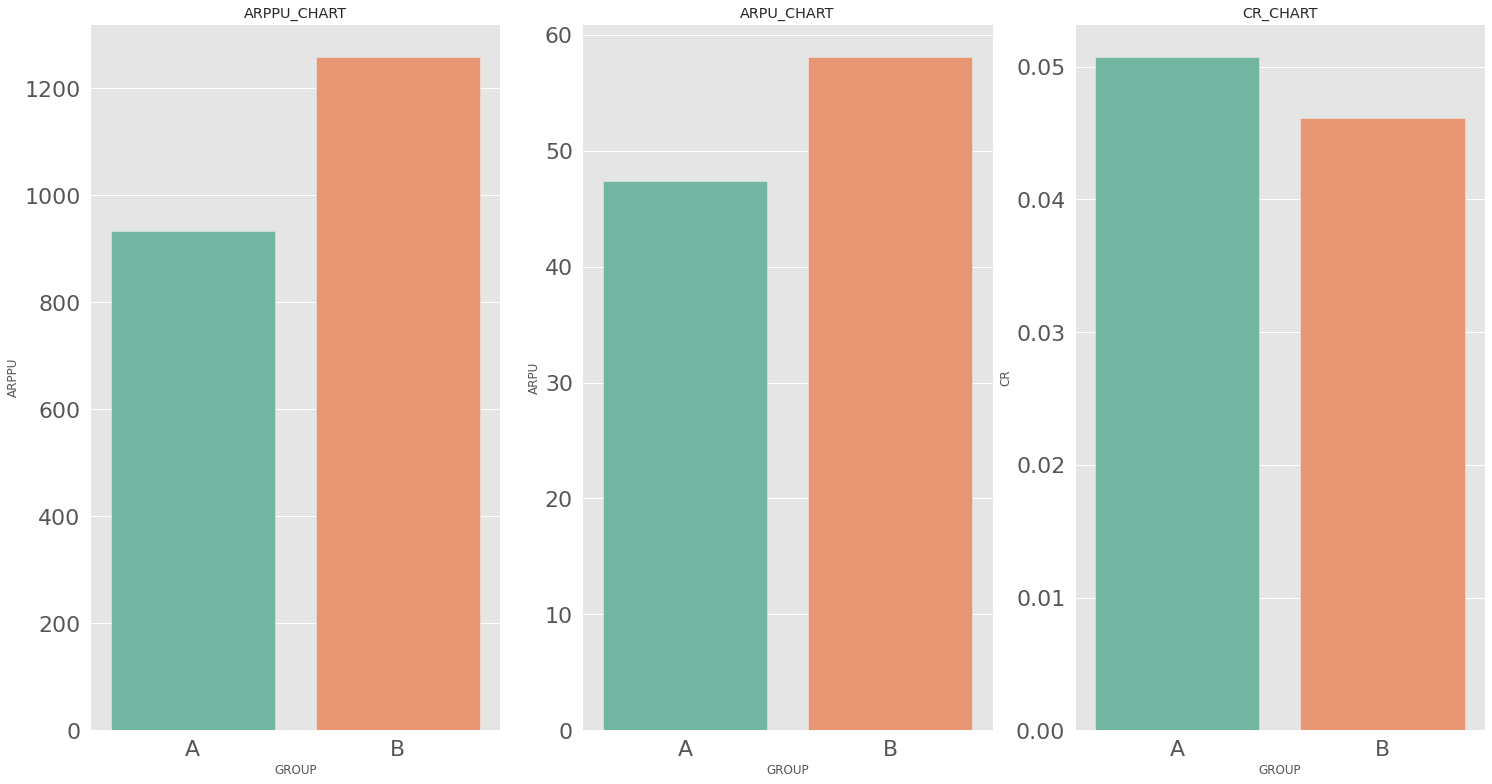

In [76]:
metrics_chart(metrics)